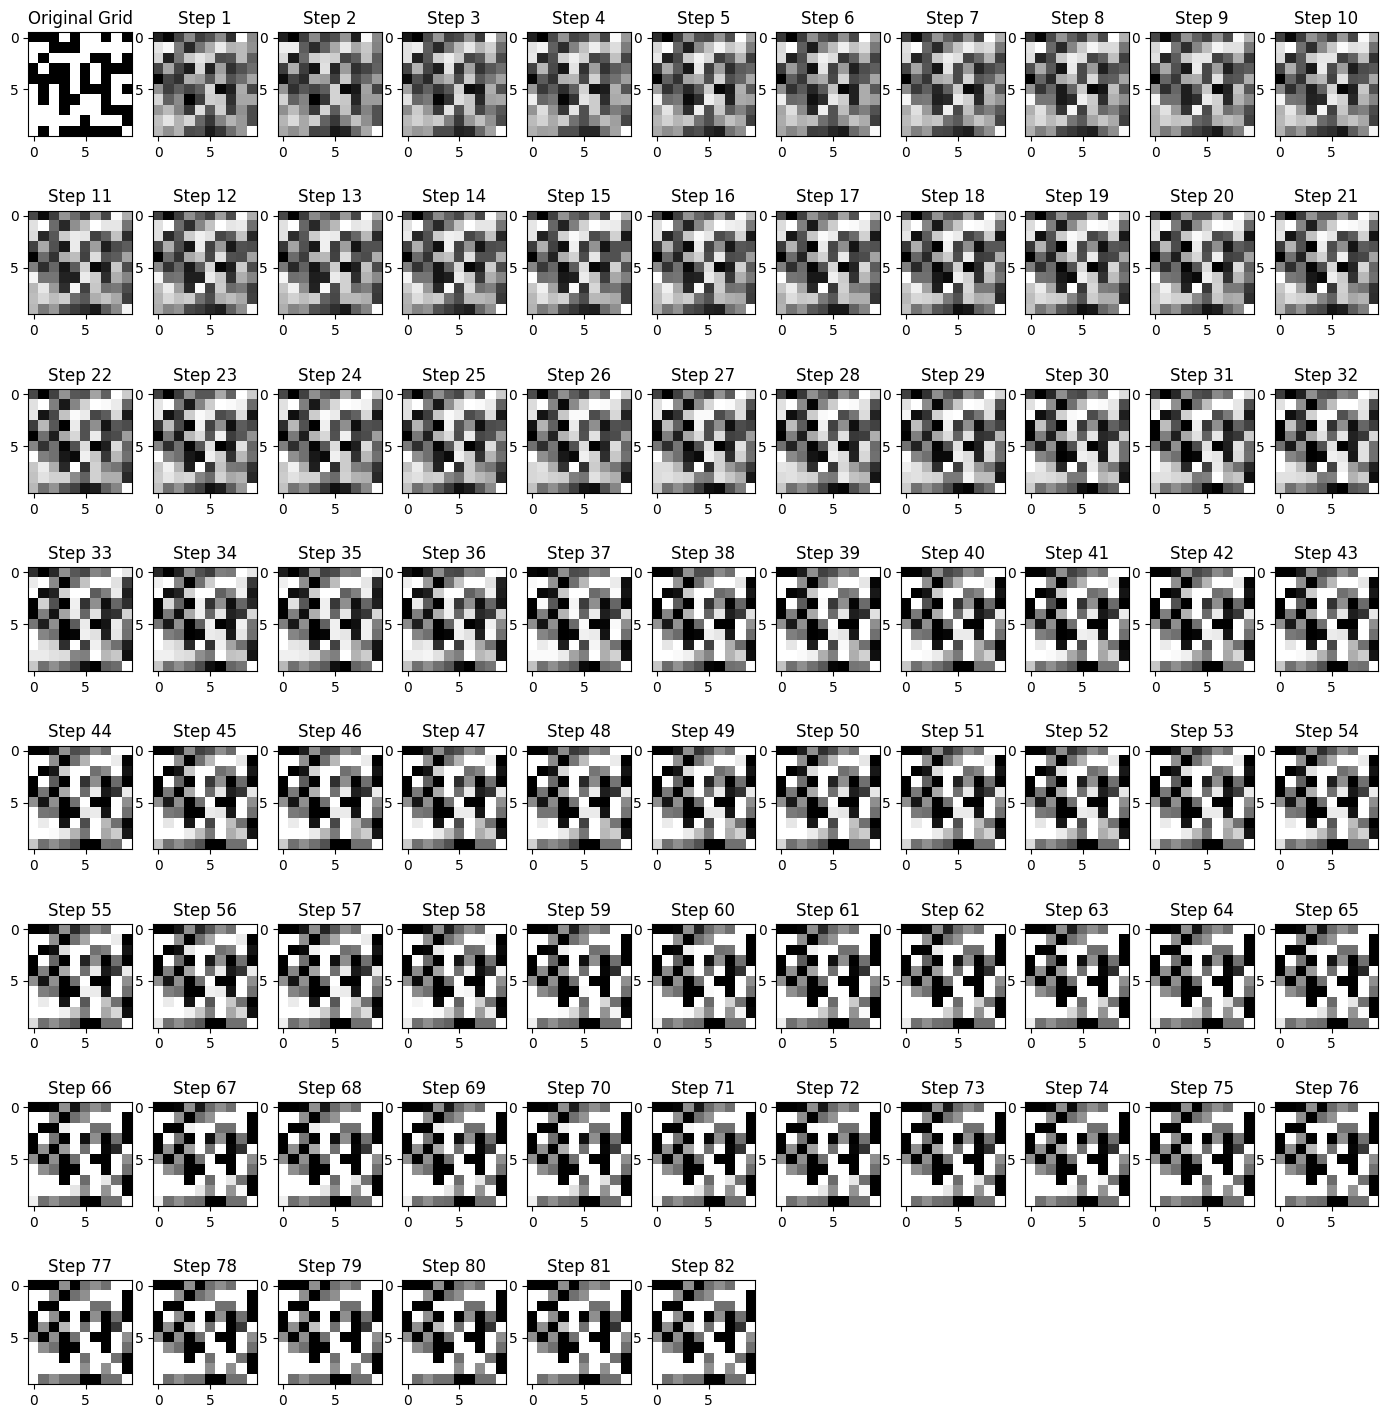

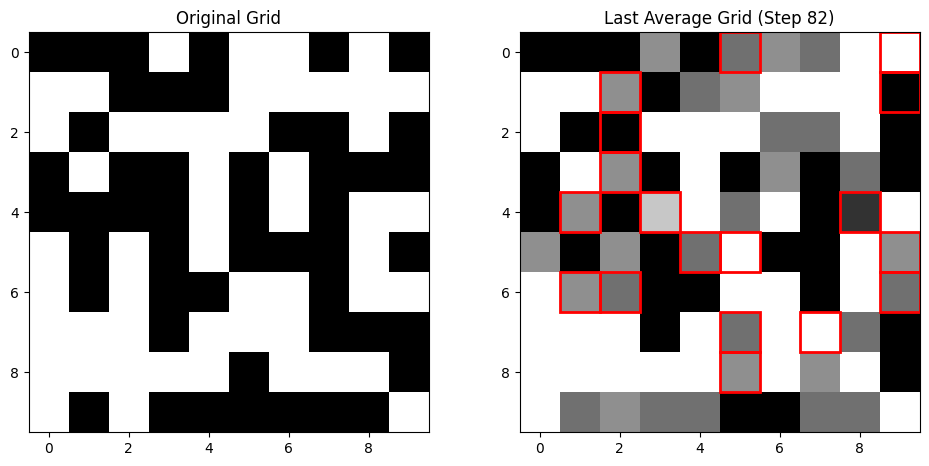

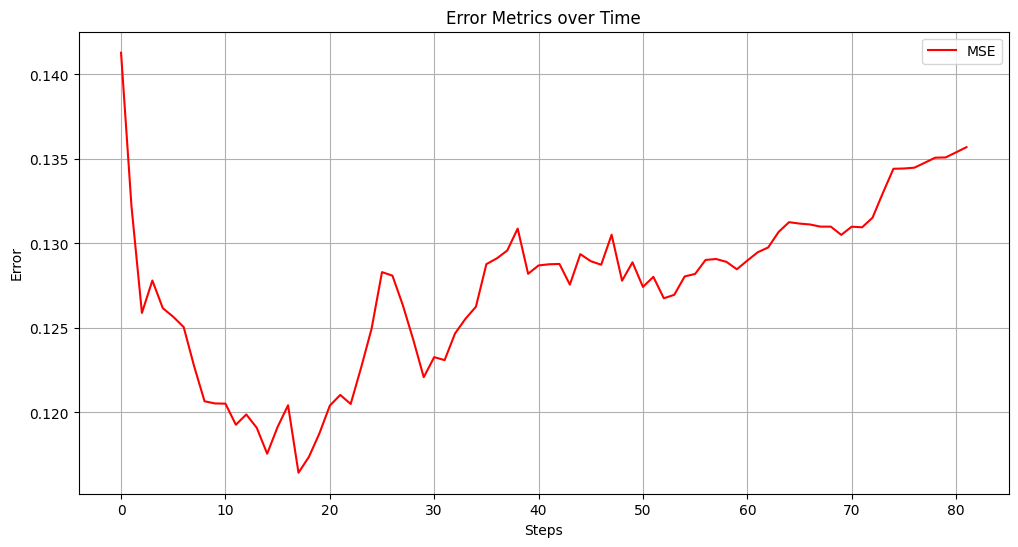

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
import networkx as nx
import seaborn as sns
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

class InformationAgent(Agent):
    """ An agent with a grid. """
    def __init__(self, unique_id, model, initial_grid, error_rate):
        super().__init__(unique_id, model)
        self.grid_size = initial_grid.shape[0]
        self.error_rate = error_rate
        # Initialize grid with the provided initial grid and introduce errors
        self.grid = self._introduce_errors(initial_grid)

    def _introduce_errors(self, grid):
        """ Introduce random errors into the grid based on error_rate. """
        flat_grid = grid.flatten()
        random_numbers = np.random.rand(flat_grid.size)
        flat_grid[random_numbers < self.error_rate] = 1 - flat_grid[random_numbers < self.error_rate]
        return flat_grid.reshape(grid.shape)

    def step(self):
        """ Agent takes a step in the simulation. """
        # Choose neighbors
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        
        if len(neighbors) < 2:
            return  # Not enough neighbors to proceed

        # Choose two random neighbors
        neighbor1, neighbor2 = self.random.sample(neighbors, 2)
    
        # Extract grids
        grid1 = self.grid
        grid2 = neighbor1.grid
        grid3 = neighbor2.grid
    
        # Check that all grids have the same shape
        if grid1.shape != grid2.shape or grid1.shape != grid3.shape:
            raise ValueError("All grids must have the same shape.")
    
        # Stack the grids and compute the majority grid
        stacked_grids = np.stack([grid1, grid2, grid3], axis=-1)
        majority_grid = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=-1, arr=stacked_grids)
        
        # Update the grids of all involved agents to the majority grid
        self.grid = majority_grid
        neighbor1.grid = majority_grid
        neighbor2.grid = majority_grid

class InformationSpreadModel(Model):
    """ Model to simulate the spread of information. """
    def __init__(self, N, grid_size, graph, error_rate, initial_grid, patience=10):
        self.num_agents = N
        self.grid = NetworkGrid(graph)
        self.grid_size = grid_size
        self.schedule = RandomActivation(self)
        self.original_grid = initial_grid
        self.avg_grids = []
        self.mse_list = []
        self.steps_taken = 0
        self.patience = patience
        self.no_improvement_counter = 0
        self.graph = graph

        # Create agents on the network
        for i in range(self.num_agents):
            a = InformationAgent(i, self, self.original_grid, error_rate)
            node = list(graph.nodes)[i % len(graph.nodes)]  # Place agent on nodes
            self.grid.place_agent(a, node)
            self.schedule.add(a)

    def step(self):
        if self.no_improvement_counter >= self.patience:
            self.running = False
            return

        previous_mse = self.mse_list[-1] if self.mse_list else float('inf')
        self.schedule.step()
        self._record_average_grid()
        mse = self.compute_distance()
        self.mse_list.append(mse)
        self.steps_taken += 1

        if mse >= previous_mse:
            self.no_improvement_counter += 1
        else:
            self.no_improvement_counter = 0

    def _record_average_grid(self):
        grids = [agent.grid for agent in self.schedule.agents]
        avg_grid = np.mean(grids, axis=0)
        self.avg_grid = avg_grid
        self.avg_grids.append(avg_grid)
        
    def compute_distance(self):
        mse = np.mean((self.original_grid - self.avg_grid) ** 2)
        return mse

    def plot_sim_results(self):
        """ Plot the average grids and the original grid. """
        num_steps = len(self.avg_grids)
        cols = 10
        rows = (num_steps + cols - 1) // cols
        plt.figure(figsize=(15, rows * 5))
        plt.subplot(rows, cols + 1, 1)
        plt.imshow(self.original_grid, cmap="binary")
        plt.title("Original Grid")
        for i, avg_grid in enumerate(self.avg_grids):
            plt.subplot(rows, cols + 1, i + 2)
            plt.imshow(avg_grid, cmap="binary")
            plt.title(f"Step {i + 1}")
        plt.subplots_adjust(left=0.05, right=0.95, top=0.4, bottom=0.05, wspace=0.2, hspace=0.2)
        plt.show()

    def plot_sim_last_results(self):
        """ Plot the original grid and the last average grid side by side, highlighting differences. """
        if not self.avg_grids:
            print("No average grids available to plot.")
            return
        
        # Calculate the differences between the original grid and the last average grid
        last_avg_grid = self.avg_grids[-1]
        difference = self.original_grid != np.round(last_avg_grid)
        
        plt.figure(figsize=(10, 5))
        
        # Plot the original grid
        plt.subplot(1, 2, 1)
        plt.imshow(self.original_grid, cmap="binary")
        plt.title("Original Grid")
        
        # Plot the last average grid
        plt.subplot(1, 2, 2)
        plt.imshow(last_avg_grid, cmap="binary")
        plt.title(f"Last Average Grid (Step {len(self.avg_grids)})")
        
        # Highlight the differences
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if difference[i, j]:
                    plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, edgecolor='red', facecolor='none', lw=2))
        
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.2)
        plt.show()

    def plot_sim_metrics(self):
        """ Plot MSE over time. """
        plt.figure(figsize=(12, 6))
        plt.plot(range(self.steps_taken), self.mse_list, label="MSE", color="red")
        plt.xlabel("Steps")
        plt.ylabel("Error")
        plt.title("Error Metrics over Time")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_network(self):
        """ Plot the network of agent connections. """
        pos = nx.spring_layout(self.graph)  # Layout for network visualization
        nx.draw(self.graph, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=16, font_weight='bold')
        plt.title('Agent Network')
        plt.show()

    def run_simulation(self):
        """ Run the simulation until early stopping criteria are met. """
        while self.running:
            self.step()
        self.plot_sim_last_results()
        self.plot_sim_metrics()
        self.plot_network()

# Example usage
def run_simulation():
    grid_size = 10
    num_agents = 50
    error_rate = 0.4
    num_steps = 100

    # Create an initial grid with random 0s and 1s
    initial_grid = np.random.randint(2, size=(grid_size, grid_size))
    
    # Create a random network (Erdős-Rényi graph)
    #G = nx.erdos_renyi_graph(num_agents, 0.5)  # 50 nodes, 30% probability of edge creation
    G = nx.powerlaw_cluster_graph(num_agents, m=1, p=0.1, seed=42)

    
    # Initialize the model
    model = InformationSpreadModel(num_agents, grid_size, G, error_rate, initial_grid)
    
    # Run the model for a number of steps
    for _ in range(num_steps):
        model.step()
    
    # Plot results
    model.plot_sim_results()
    model.plot_sim_last_results()
    model.plot_sim_metrics()
    #model.plot_network()

# Run the simulation
run_simulation()